In [8]:
# Cella 1: Reset, Clone e Configurazione Ambiente

import os
import sys

# 1. --- RESET AMBIENTE ---
# Torna alla directory di base di Colab (/content/) e rimuovi il repository
# Questo previene problemi di annidamento e path errati.
print("Esecuzione Reset Ambiente...")
try:
    os.chdir('/content/')
    # Rimuovi la cartella clonata se esiste, per evitare annidamenti al prossimo clone
    !rm -rf Hawk-AI-CV-Project
except Exception as e:
    print(f"Errore durante il reset: {e}. Continuo...")

# 2. --- CLONAZIONE ---
# Clona il tuo repository nella cartella /content/
!git clone https://github.com/leonardoCosta02/Hawk-AI-CV-Project.git

# 3. --- CAMBIO DIRECTORY (CD) E PATH ---
repo_name = "Hawk-AI-CV-Project"
# Spostati nella root del tuo progetto
%cd $repo_name

# Aggiungi la directory corrente (la radice del repo) al PATH di Python
sys.path.insert(0, os.getcwd())

# 4. --- INSTALLAZIONE LIBRERIE ---
print("Installazione librerie necessarie...")
# Usiamo i comandi standard per garantire l'ambiente
!pip install numpy opencv-python matplotlib

print("\nSetup completato. Ora la tua root è:")
print(os.getcwd())

Esecuzione Reset Ambiente...
Cloning into 'Hawk-AI-CV-Project'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 92 (delta 19), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (92/92), 1.81 MiB | 8.46 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/Hawk-AI-CV-Project
Installazione librerie necessarie...

Setup completato. Ora la tua root è:
/content/Hawk-AI-CV-Project


In [9]:
# Cella 2: Caricamento Dati, Pre-processing e Fix Cache

# --- IMPORTAZIONE DEI MODULI NECESSARI ---
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import importlib # Necessario per il ricaricamento dei moduli

# Importa i moduli la prima volta (dal tuo percorso 'src')
from src import config
from src import court_features # Importa il modulo completo

# --- 1. PULIZIA FORZATA E RICARICAMENTO (FIX DEL TYPERROR) ---
print("Ricaricamento forzato dei moduli per pulizia cache...")

# Forza il ricaricamento di entrambi i moduli per ignorare la vecchia firma della funzione
config = importlib.reload(config)
court_features = importlib.reload(court_features)

# Ora puoi importare la funzione 'trova_linee' dalla versione aggiornata
from src.court_features import trova_linee

print("Moduli aggiornati. La funzione trova_linee ha ora la firma corretta (2 argomenti).")

# --- 2. LOGICA DI CARICAMENTO DATI ---
# (Assumiamo che CAMPI_PATH sia stata aggiunta nel config.py)
immagini_caricate = {}

print("\nCaricamento frame per le 3 superfici...")

# Usa config.CAMPI_PATH per il loop di caricamento
for superficie, path in config.CAMPI_PATH.items():

    # Continua con il caricamento
    image_bgr = cv.imread(path)

    if image_bgr is None:
        print(f"ERRORE CRITICO: Impossibile caricare l'immagine da {path}.")
        print("PASSAGGIO MANCANTE: Controlla che i file JPG siano fisicamente in /content/Hawk-AI-CV-Project/data/.")
    else:
        # Carica in BGR (per processing) e RGB (per visualizzazione)
        immagini_caricate[superficie] = {
            'bgr': image_bgr,
            'rgb': cv.cvtColor(image_bgr, cv.COLOR_BGR2RGB)
        }

if not immagini_caricate:
    print("Nessun frame caricato. Termino l'esecuzione.")
else:
    print(f"Caricamento completato per {len(immagini_caricate)} tipi di campo.")

Ricaricamento forzato dei moduli per pulizia cache...
Moduli aggiornati. La funzione trova_linee ha ora la firma corretta (2 argomenti).

Caricamento frame per le 3 superfici...
Caricamento completato per 3 tipi di campo.



== TEST SUPERFICIE: CEMENTO ==
   Parametri CANNY usati: LOW=25, HIGH=100
   Soglia HOUGH usata: 70

✅ OUTPUT M3 (PRIME 5 LINEE per CEMENTO):
[[  0   7 274   7]
 [  0   4 274   4]
 [ 25  55 246  55]
 [ 25 130 248 130]
 [ 25  42 249  42]]
Forma dell'array: (18, 4)


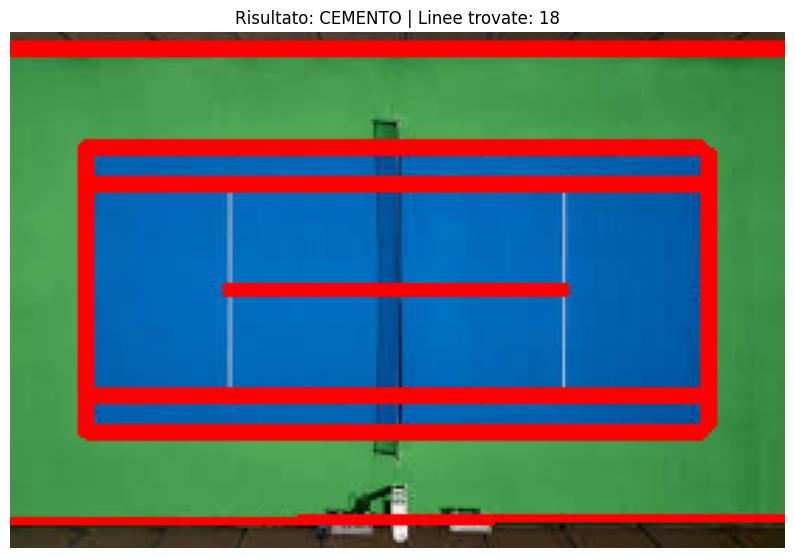


== TEST SUPERFICIE: ERBA ==
   Parametri CANNY usati: LOW=30, HIGH=120
   Soglia HOUGH usata: 65


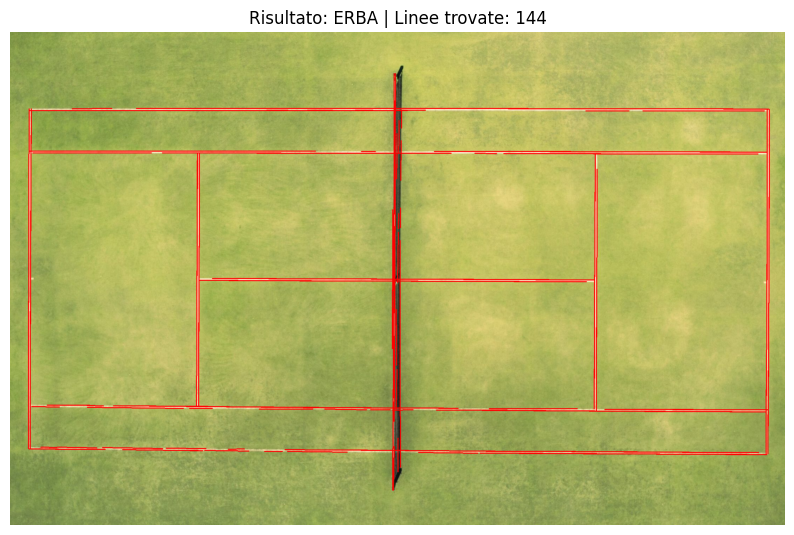


== TEST SUPERFICIE: TERRA_BATTUTA ==
   Parametri CANNY usati: LOW=40, HIGH=180
   Soglia HOUGH usata: 30


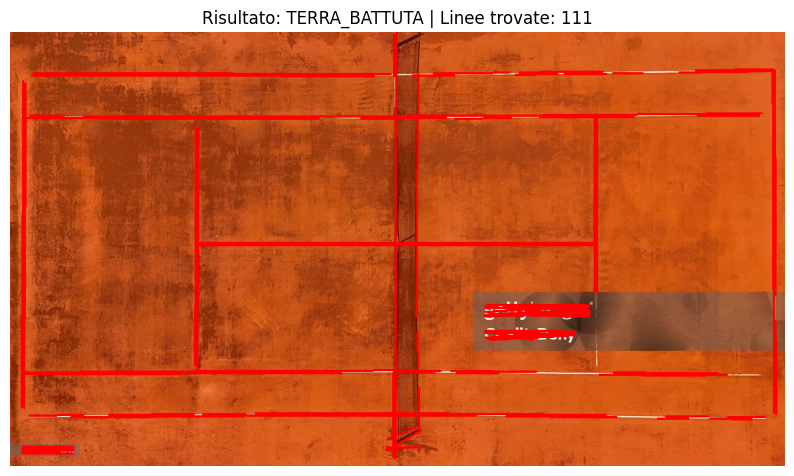


======================= RIEPILOGO COMPLETO =======================
OBIETTIVO DI TUNING: Ottenere circa 10-15 linee trovate e ben disegnate per campo.

SUPERFICIE: CEMENTO
  -> Linee Trovate: 18
  -> Canny/Hough Usati: 100/70

SUPERFICIE: ERBA
  -> Linee Trovate: 144
  -> Canny/Hough Usati: 120/65

SUPERFICIE: TERRA_BATTUTA
  -> Linee Trovate: 111
  -> Canny/Hough Usati: 180/30

PASSAGGIO FINALE:
1. Analizza i tre grafici (CEMENTO, ERBA, TERRA_BATTUTA).
2. Se le linee sono spezzate o non sono rilevate correttamente, modifica i parametri nel file config.py.
3. Riavvia la pipeline (Esegui Cella 1, Cella 2, Cella 3) fino a trovare l'ottimale per tutti i campi.


In [11]:
# Cella 3: Esecuzione del Loop di Tuning e Visualizzazione dei Risultati

# Nota: Assicurati che le Celle 1 e 2 siano state eseguite senza errori per avere 'immagini_caricate' e 'config' disponibili.

risultati_finali = {}

# --- 1. LOOP DI TUNING PER OGNI SUPERFICIE ---

for superficie, dati_immagine in immagini_caricate.items():

    # Recupera i parametri dal file di configurazione
    # (Questa riga funziona perché la Cella 2 ha ricaricato correttamente il modulo config)
    params = config.ALL_SURFACE_PARAMS[superficie]

    print(f"\n========================================================")
    print(f"== TEST SUPERFICIE: {superficie} ==")
    print(f"   Parametri CANNY usati: LOW={params['CANNY_LOW']}, HIGH={params['CANNY_HIGH']}")
    print(f"   Soglia HOUGH usata: {params['HOUGH_THRESHOLD']}")
    print(f"========================================================")

    # --- ESECUZIONE DELLA FUNZIONE (Pulita) ---
    raw_line_segments = trova_linee(dati_immagine['bgr'], superficie)

    # --- AGGIUNGI QUI LA STAMPA PER IL MEMBRO 3 ---
    if superficie == 'CEMENTO':
        print(f"\n✅ OUTPUT M3 (PRIME 5 LINEE per {superficie}):")
        # Stampa i segmenti come array NumPy in formato [[x1, y1, x2, y2], ...]
        print(raw_line_segments[:5])
        print(f"Forma dell'array: {raw_line_segments.shape}")
    # -----------------------------------------------

    # --- 2. VISUALIZZAZIONE DEI RISULTATI ---
    line_frame = np.copy(dati_immagine['rgb'])
    linee_trovate = len(raw_line_segments)

    if linee_trovate > 0:
        # Disegna tutte le linee trovate in ROSSO sul frame
        for x1, y1, x2, y2 in raw_line_segments:
            cv.line(line_frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Visualizza il risultato
    plt.figure(figsize=(10, 8))
    plt.imshow(line_frame)
    plt.title(f"Risultato: {superficie} | Linee trovate: {linee_trovate}")
    plt.axis('off')
    plt.show()

    # 3. Registra i risultati per il riepilogo
    risultati_finali[superficie] = {
        'Canny Low': params['CANNY_LOW'],
        'Canny High': params['CANNY_HIGH'],
        'Hough Threshold': params['HOUGH_THRESHOLD'],
        'Totale Linee Trovate': linee_trovate,
        'Raw Segments': raw_line_segments # Teniamo l'array completo registrato
    }

# --- RIEPILOGO FINALE ---
print("\n======================= RIEPILOGO COMPLETO =======================")
print("OBIETTIVO DI TUNING: Ottenere circa 10-15 linee trovate e ben disegnate per campo.")

for superficie, params in risultati_finali.items():
    print(f"\nSUPERFICIE: {superficie}")
    print(f"  -> Linee Trovate: {params['Totale Linee Trovate']}")
    print(f"  -> Canny/Hough Usati: {params['Canny High']}/{params['Hough Threshold']}")

print("\n==================================================================")
print("PASSAGGIO FINALE:")
print("1. Analizza i tre grafici (CEMENTO, ERBA, TERRA_BATTUTA).")
print("2. Se le linee sono spezzate o non sono rilevate correttamente, modifica i parametri nel file config.py.")
print("3. Riavvia la pipeline (Esegui Cella 1, Cella 2, Cella 3) fino a trovare l'ottimale per tutti i campi.")